<a href="https://colab.research.google.com/github/Michael-Jimenez-C/CieCom2/blob/main/proyecto_CII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sympy as sp

In [2]:
class Cuarto:
  def __init__(self,capacitancia,temperatura,fuente=0,Rfuente=1):
    t=sp.symbols("t")
    self.temperatura=temperatura
    self.adyacentes=[]#[(nodo,resistencia)]
    self.capacitancia=capacitancia
    self.fuente=fuente
    self.Rfuente=Rfuente
  def eq(self):
    equ=0
    if type(self.fuente)!=list:
      equ+=(self.fuente-self.temperatura if self.fuente!=0 else 0)/self.Rfuente
    else:
      for i,j in zip(self.fuente,self.Rfuente):
        equ+=(i-self.temperatura if i!=0 else 0)/j
    for i in self.adyacentes:
      equ+=(i[0].temperatura-self.temperatura)*sp.Rational(1,i[1])
    return sp.simplify(equ*sp.Rational(1,self.capacitancia))

aire
$$C_a=(\rho*V)*c=\approx 0.29kcal/m^3*V$$
$\rho=\frac{P_s}{287.058j/(kg*K)\cdot T_a}=\text{densidad del aire}\approx1.2kg/m^3$

$c\approx0.24$

No varía significativamente entre 0 y 40 grados, y la variación entre aire humedo y seco no es muy significativa

Agua

$$C_a\approx1000kcal/m^3$$
$c=1$

Suponiendo pisos de 2.5m de alto:
$C_a=0.725kcal/m^2*A$

In [3]:
resistencias_termicas = {
    'Ladrillo': 0.069, # en m²K/W
    'Bloque de concreto': 0.110,
    'Hormigón': 0.800,
    'Fibra de vidrio': 3.040,
    'Lana mineral': 2.800,
    'Poliestireno expandido': 0.038,
    'Poliestireno extruido': 0.035,
    'Aislamiento de celulosa': 0.050,
    'Aislamiento de corcho': 0.043,
    'Aislamiento de lana de oveja': 0.045,
    'Aislamiento de fibra de cáñamo': 0.044,
    'Drywall': 0.131
}


In [4]:
t,s=sp.symbols("t s")
T1,T2,T3=sp.symbols("T_{1} T_{2} T_{3}")
A1=Cuarto(0.725*25,T1,sp.symbols("T_{i1}"))
B1=Cuarto(0.725*25,T2,0)
C1=Cuarto(0.725*25,T3,sp.symbols("T_{i2}"))

A1.adyacentes=[(B1,resistencias_termicas["Drywall"])]
B1.adyacentes=[(A1,resistencias_termicas["Drywall"]),(C1,resistencias_termicas["Ladrillo"])]
C1.adyacentes=[(A1,resistencias_termicas["Ladrillo"])]

nodos=[A1,B1,C1]

In [5]:
nodos[1].eq()

36028797018963968*T_{1}/85545874921902575 - 129807421463370697919021812023296*T_{2}/106332966236296333620382700511775 + 144115188075855872*T_{3}/180234057087367265

In [60]:
variables=sp.symbols("T_{1} T_{2} T_{3}")
entradas=[sp.symbols("T_{i1}"),sp.symbols("T_{i2}")]
A=[]
B=[]
for i in range(len(nodos)):
  A.append([])
  B.append([])
  eq=nodos[i].eq()
  for j in range(len(variables)):
    A[-1].append(eq.coeff(variables[j]))
  for j in range(len(entradas)):
    B[-1].append(eq.coeff(entradas[j]))

A=sp.N(sp.Matrix(A),2)
B=sp.N(sp.Matrix(B),2)
C=sp.Matrix([[1 for i in range(A.shape[0])]])
A,B

(Matrix([
 [-0.48, 0.42,     0],
 [ 0.42, -1.2,   0.8],
 [  0.8,    0, -0.85]]),
 Matrix([
 [0.055,     0],
 [    0,     0],
 [    0, 0.055]]))

In [ ]:
class Edificio:
  pass

r

In [61]:
def eAt(A,t):
  T,D=sp.N(A,2).diagonalize()
  return T*sp.exp(D*t)*T.inv()

In [62]:
x0=sp.Matrix([[0],[0],[0]])
u=sp.Matrix([[50],[30]])

In [63]:
def solucionTiempo(A,B,x0,u):
  t=sp.symbols("t")
  EAT=eAt(A,t)
  tau=sp.symbols("\tau") 
  return EAT*x0+sp.integrate(EAT.subs(t,tau)*B*u.subs(t,t-tau),(tau,0,t))

In [11]:
def solucionFrecuencia(A,B,x0,u):
  t,s=sp.symbols("t s")
  U=sp.laplace_transform(u,t,s,noconds=True)
  Y=(s*sp.eye(A.shape[0])-A).inv()@(x0+B*U)
  sol=sp.inverse_laplace_transform(sp.expand(Y),s,t)
  return sol


In [ ]:
sol=solucionFrecuencia(A,B,x0,u)
sol
sp.N(sol[0].subs(t,10))

In [65]:
sol=solucionTiempo(A,B,x0,u)
sol
sp.N(sol[0].subs(t,10))

16.2347970956638 + 2.03344589e-11*I

In [66]:
sp.N(sol[2].subs(t,1000))

43.9791618882929 + 2.853686648e-10*I

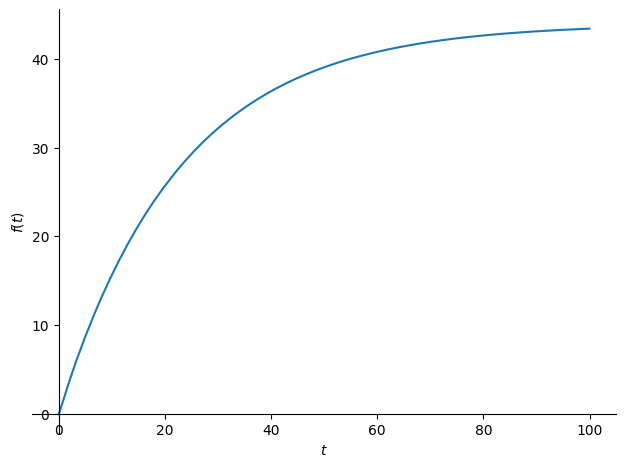

In [59]:
sp.plot(sol[2],(t,0,100))